<a href="https://colab.research.google.com/github/JoeVonDahab/Deep-Learning-Class/blob/P_1/Homework_MNIST_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# This is formatted as code
```

# Homework: Autoencoding MNIST and Celebrity Faces


> **Due Date: March 5th, 2025 @ 1:00pm**
>
> Please turn in this completed notebook via Google classroom. Email clay.smyth@ucsf.edu if you run into any issues.

**Collaboration policy and more**

You're welcome (and highly encouraged) to work with and discuss this homework assignment with others in the class, and feel free to use any resources (textbooks, online notebooks, etc). The only requirement is that the final notebook that you turn in must be your own written work (no copy and pasting, please).

**Overview**

In class, we cover how Hinton and Salakhutdinov's 2006 Science Paper, ["Reducing the Dimensionality of Data with Neural Networks"](https://www.science.org/doi/10.1126/science.1127647) was one of the first demonstrations of unsupervised pretraining for use in training deep neural networks. In this homework, we'll implement autoencoders in the context of MNIST. Additionally, as an optional assignment, a similar architecture can be used for a subset of CelebA dataset of celebrity faces.



Why?



## Before you get started

**1) Background reading**

Please Read Hinton and Salakhutdinov's 2006 seminal work on deep autoencoders (https://www.science.org/doi/10.1126/science.1127647), as this notebook aims to recreate this important work. A few questions to think about as you read that will help you in this assignment:
  - What architecture do they use for their deep autoencoders?
  - Why were deep neural networks so much harder to train in 2006?

**2) How to run this notebook**

This Jupyter Notebook can be used in two ways:
* *Option 1: Download the notebook*

  We've included all the imports necessary for this homework. Please make sure you're running Python 3 with PyTorch (and Torchvision) installed and ready to go, along with NumPy and Matplotlib. Although you might find that these models train a bit faster on GPU, this homework assignment should be doable on most modern laptops. If you're having trouble please let us know ASAP.

* *Option 2: Run it online on Google Colaboratory*

  - Colab gives access to a GPU, so it could be useful in case you don't have CUDA installed on your computer (**Note: you can use this as an opportunity to get started on GPU training, but we recommend you develop your model and make sure everything works on CPU first**)
  - Make a copy of this notebook in your Google Drive folder: "File" -> "Save a copy in Drive..."
  - By default, Colab does not make GPUs available, but you can easily access them by selecting GPU in "Runtime" -> "Change runtime type..."
  - Remember that Colab runs in a temporary virtual machine, so all the data created while running the notebook will be lost at the end of the session, or when the runtime disconnects due to inactivity. To preserve data between sessions, there are a couple of options:
    * you can link Colab to your personal Google Drive by mounting it on your runtime, see first cell below.
    * you can download/upload files from the Files tab on the right sidebar.

**3) How to complete this assignment**

  - Fill out the relevant code blocks as indicated
  - Answer questions by writing them directly in the text block. Please keep your written answers concise, most are meant to be answered in a sentence or two.
  - Make figures showing your results and add comments with your observations.

**4) Optional exercise: CelebA Data**

Whereas MNIST is a toy dataset built into PyTorch, we can also examine a more complex feature space using a subset of 90,000 celebrity portraits from CelebA (see [Liu et al. (2014), "Deep Learning Face Attributes in the Wild"](https://arxiv.org/abs/1411.7766)). This is an optional part of the homework, but is a nice way to see how autoencoders perform on other types of visual data. There will be a .zip file of the relevant celebrity faces dataset on the Google Classroom link.

***Let's start!***

---

## Train an autoencoder on MNIST

The following command can be used to mount your personal Google Drive folder on the temporary virtual machine, so you can recover data between sessions (follow the instructions, you'll need an authorization code). Additional info [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA).


In [ ]:
# # Skip this cell if running locally
# from google.colab import drive
# drive.mount('/content/gdrive')
 
!pip install numpy matplotlib


In [3]:
!pip install torch torchvision


  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp311-cp311-win_amd64.whl.metadata (4.1 kB)
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/204.2 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.2 MB ? eta -:--:--
   ---------------------------------------- 1.0/204.2 MB 2.6 MB/s eta 0:01:17
   ---------------------------------------- 1.3/204.2 MB 2.7 MB/s eta 0:01:16
   ---------------------------------------- 2.1/204.2 MB 2.7 MB/s eta 0:01:16
   ---------------------------------------- 2.4/204.2 MB 2.4 MB/s eta 0:01:25
    --------------------------------------- 2.9/204.2 MB 2.4 MB/s eta 0:01:23
    --------------------------------------- 3.7/204.2 MB 2.5 MB/s eta 0:01:21
    --------------------------------------- 4.2/204.2

In [4]:
# Import all the necessary libraries
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

from IPython.display import Image, display

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms
from torchvision.utils import save_image

You shouldn't need CUDA for this assignment, but if you want a head start, or if you just want to see the difference between using a CPU versus a GPU, set `use_cuda = True` below.
You can check if CUDA is available on your computer with: `torch.cuda.is_available()`

If you are working on Colab, make sure to activate the GPU ("Runtime" -> "Change runtime type...").

In [5]:
torch.cuda.is_available()

False

In [6]:
use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")

In [7]:
torch.manual_seed(7);

> **Question 0.1) Why is it important to set the seed for the random number generator?**

For results reproducability. whenever a random number or action is generated. if you set the seed to particular number you can regenerate the same value


### 1. MNIST Dataset

As noted in class, MNIST has been widely used to benchmark new deep learning architectures and is already built into PyTorch. We provide this data as a starting point, again noting that the mean and std of the training set are calculated to be 0.1307 and 0.3081, respectively.

In [8]:
preprocessing = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST(
    './bmi219_downloads', train=True, download=True,
    transform=preprocessing)

test_dataset = datasets.MNIST(
    './bmi219_downloads', train=False, download=True,
    transform=preprocessing)

100.0%
100.0%
100.0%
100.0%


In [11]:
# Get the length (number of samples) of the dataset
print(f"Number of samples: {len(train_dataset)}")

# Get the shape of a single sample
sample, label = train_dataset[0]  # Get first sample and its label
print(f"Shape of a single sample: {sample.shape}")

Number of samples: 60000
Shape of a single sample: torch.Size([1, 28, 28])


In [18]:
train_dataset[123][0].size()

torch.Size([1, 28, 28])

> **Q1.1) How many examples do the training set and test set have?**

60,000 for training dataset and 10,000 for test dataset

> **Q1.2) What's the format of each input example? Can we directly put these into a fully-connected layer?**

the format is 28 by 28 picture with 1 colour which is grey (black and white). 

no we can't we can use a cnn instead to convert it into a meaningful representation that can be eventually put into dense layer for classification or whatever other task might be

> **Q1.3) Why do we normalize the input data for neural networks?**

We normalize input data for neural networks because:
- Normalization ensures all input features are on a similar scale. they're transformed to have similar magnitudes. This prevents features with larger scales from dominating the learning process.
- It helps the network converges faster
- It prevents mathematical problems that can occur with very large or small numbers
- ensure stability

> **Q1.4) In this scenario, MNIST is already split into a training set and a test set. What is the purpose of dataset splitting (and specifically, the purpose of a test set)? For modern deep learning, a three-way split into training, validation, and test sets is usually preferred, why?**

The training dataset is used to train the model to learn the pattern and relationship between features and output. However its unknown how accurate would it performe on other data outside the learnning dataset. So, a test dataset serves as benchmark that can see how the model performs on unseen data

it helps assesing the model whether its overfitting or underfitting, whether it even works or not

nowdays a 3 split is more common to prevent data leakage phenomena, where the data is overfit to match the test data set. instead its tested on validation data first, and test data set is conserved lastly to test the best model possible performance

### 2. Using DataLoaders for MNIST

Set up the DataLoader objects below. Although the arguments are prepopulated, you may need to change the batch sizes or other arguments during training.

In [19]:
BATCH_SIZE = 30  # <-- Please change this as necessary
NUM_WORKERS = 4  # <-- Use more workers for more CPU threads

In [20]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS)

In [21]:
one_batch=next(iter(train_loader))
one_batch[0].size()

torch.Size([30, 1, 28, 28])

> **Q2.1) It's recommended to shuffle the training data over each epoch, but this isn't typically the case for the test set, why?**

there are mutpile reasons:

- prevent order memorization by the model. because the model may get lazy and try to predict based on order of example rather than its actual value
- randomization helps escaping local minimum, it helps leading the model to different direction in the gradient space
- reduce bias, when each batch has different mix each time
- ensure model stability and reprodcuability 

there is no need to shuffle test data set because you don't learn from them. the model weight is fixed at that point.

also you don't mix test and training data to prevent leakage

> **Q2.2) What seems to be a good batch size for training? What happens if you train with a batch size of 1? What about a batch size equal to the total training set?**

a batch size tpyically represent group of data in which the model updates its gradient based on. It is advisable to use batch size of more than one (typically between 32 and 128) to prevent model instability. if its too short the gradient update may be too random and unstable. Also if its too large the model may not converges and may stuck in local minimum

> **Q2.3) The PyTorch DataLoader object is an iterator that generates batches as it's called. Try to pull a few images from the training set to see what these images look like. Does the DataLoader return only the images? What about the labels?**

no it returns also labels of each image, they look black and white with very low resolution handwritten 

Batch shape: torch.Size([30, 1, 28, 28])
Labels shape: torch.Size([30])


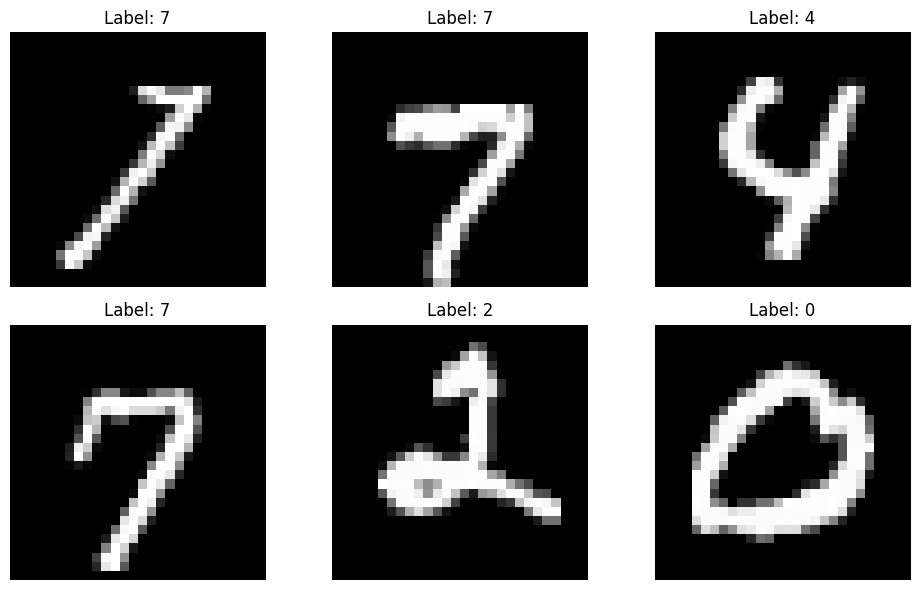

First few labels in this batch: [7, 7, 4, 7, 2, 0]


In [23]:
# Get a single batch from the training loader
images, labels = next(iter(train_loader))

# Print the shapes
print(f"Batch shape: {images.shape}") 
print(f"Labels shape: {labels.shape}")  

# Visualize first 6 images from the batch
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
for i, ax in enumerate(axes.flat):
    if i < 6:
        # Plot image
        ax.imshow(images[i].squeeze(), cmap='gray')
        # Add label as title
        ax.set_title(f'Label: {labels[i].item()}')
        ax.axis('off')
plt.tight_layout()
plt.show()

# Print first few labels
print("First few labels in this batch:", labels[:6].tolist())


### 3. Define your neural network architecture

With your data and dataloaders appropriately set, you're ready to define a network architecture. In this homework, we'll ask you to evaluate two different architectures.

For the first (we'll call it `HNet` in this homework), please implement Hinton's 2006 architecture of 7-hidden layers:

```[784 x 1000 x 500 x 250 x 2 x 250 x 500 x 1000 x 784]. ```

For the second, implement your own autoencoder architecture, `MyNet`, again using a bottleneck dimension of 2. As a note, the larger your model, the longer it will take to train. Can you achieve similar performance to the model above using a more condensed model?

**Tips:**
* Try different activation functions (Tanh, Sigmoid, ReLU, etc)
* A sequence of layers can be defined more easily using `nn.Sequential`, see [docs](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html#torch.nn.Sequential)
* Split your network into an `.encoder()` and a `.decoder()`, that will be called sequentially in `.forward()`. This will be useful later on when we'll ask to visualize the low-dimensional embeddings ("latent space") produced by the encoder.

In [24]:
class HNet(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU(),
            nn.Linear(250, 2)  # Bottleneck
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.Sigmoid()  # Output between 0 and 1 for images
        )

    def forward(self, x):
        x = x.view(-1, 784)  # Flatten the input
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [31]:
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        ### Fill in your network architecture here
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 64), 
            nn.ReLU(),
            nn.Linear(64, 2)  # Bottleneck
        )
        
        # Decoder 
        self.decoder = nn.Sequential(
            nn.Linear(2, 64),
            nn.ReLU(),
            nn.Linear(64, 256),
            nn.ReLU(), 
            nn.Linear(256, 784),
            nn.Sigmoid()  # Output between 0 and 1 for images
        )
        pass

    def forward(self, x):
        ### Implement the forward pass
        x = x.view(-1, 784)  # Flatten the input
        x = self.encoder(x)  # Pass through encoder
        x = self.decoder(x)  # Pass through decoder
        x = x.view(-1, 1, 28, 28)  # Reshape back to image dimensions
        return x
        pass

> **Q3.1) What activation functions did you use, and why?**

I used reLU, because it manages to capture non-linear relationships, but in the sam etime it doesn't have the problems associated with sigmoid function such as vanishing gradients, and heavy computation

sigmoid gradients is very small also espcially towards the extreme (infinity) which makes convergance slower

### 4. Write your own training function

Write your own training function that takes your **model**, an **optimizer**, and a **training criterion**, and iterates over the **training set**.
* *Hint*: Because an autoencoder is a form of unsupervised learning, we won't need to use the labels like in the MNIST classification example. Keep in mind the format of the images and whether they're compatible with feed-forward networks.
* For each epoch, print and record (in an array or list) the training loss.
* You may want to save the model and its weights on file at regular intervals ([checkpointing](https://pytorch.org/tutorials/beginner/saving_loading_models.html#saving-loading-model-for-inference)). In order to visualize the autoencoder's learning process, we suggest to save at least three timepoints: early, intermediate, and final (for instance, if your model converges after 60 epochs, save your model at 5 epochs, 30 epochs, and 60 epochs).

A few useful tips:
- Feel free to look at the MNIST classification notebook from previous recitations and use it as a template.
- Printing out the intermediate variables and their shape at each step can be helpful for debugging.

In [36]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Set training mode for the model (not the loader!)
    losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        num_batches = 0
        
        # Iterate directly over train_loader
        for batch_idx, (data, _) in enumerate(train_loader):
            # Move data to device
            data = data.to(device)
            
            # Forward pass
            output = model(data)
            loss = criterion(output, data)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Track loss
            epoch_loss += loss.item()
            num_batches += 1
            
            if batch_idx % 100 == 0:
                print(f'Epoch {epoch}: [{batch_idx}/{len(train_loader)}]\tLoss: {loss.item():.6f}')
        
        # Average loss for the epoch
        avg_loss = epoch_loss / num_batches
        losses.append(avg_loss)
        print(f'Epoch {epoch} complete. Average loss: {avg_loss:.6f}')
    
    return losses

### 5. Define your optimization and evaluation criterion

Define an optimizer and criterion (loss function) for your neural network training. To setup your optimizer, you'll have to instantiate your models above, and choose a learning rate. Try a few different optimizers and learning rates to get a sense of what will train within a reasonable timeframe (if your deep network isn't too deep, reaching convergence shouldn't take more than 5-10 minutes with the right choice of learning rate and optimizer).

In [39]:

# Define model and move to device
model = MyNet().to(device)

# Test different loss functions
loss_functions = {
    'MSE': nn.MSELoss(),
    'L1': nn.L1Loss(),
    'SmoothL1': nn.SmoothL1Loss()
}

# Test different optimizers and learning rates
learning_rates = [0.1, 0.01, 0.001, 0.0001]
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSprop': optim.RMSprop
}

# Number of epochs for quick testing
test_epochs = 3

# Store results
results = {}

# Test all combinations
for loss_name, criterion in loss_functions.items():
    for opt_name, opt_class in optimizers.items():
        for lr in learning_rates:
            combo_name = f"{loss_name}-{opt_name}-{lr}"
            print(f"\nTesting combination: {combo_name}")
            
            # Reset model weights
            model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
            
            # Create optimizer
            optimizer = opt_class(model.parameters(), lr=lr)
            
            # Train for a few epochs
            try:
                losses = train_model(model, train_loader, criterion, optimizer, test_epochs)
                final_loss = losses[-1]
                results[combo_name] = final_loss
                print(f"Final loss: {final_loss:.6f}")
            except Exception as e:
                print(f"Failed with error: {str(e)}")
                results[combo_name] = None

# Find best combination
best_combo = min(results.items(), key=lambda x: float('inf') if x[1] is None else x[1])
print("\nBest combination found:")
print(f"{best_combo[0]} with final loss: {best_combo[1]:.6f}")

# Print summary of all results
print("\nSummary of all results:")
for combo_name, loss in results.items():
    if loss is not None:
        print(f"{combo_name}: {loss:.6f}")
    else:
        print(f"{combo_name}: Failed")


Testing combination: MSE-SGD-0.1
Epoch 0: [0/2000]	Loss: 1.249235
Epoch 0: [100/2000]	Loss: 1.272069
Epoch 0: [200/2000]	Loss: 1.193445
Epoch 0: [300/2000]	Loss: 1.172958
Epoch 0: [400/2000]	Loss: 0.783839
Epoch 0: [500/2000]	Loss: 0.865111
Epoch 0: [600/2000]	Loss: 0.820928
Epoch 0: [700/2000]	Loss: 0.827561
Epoch 0: [800/2000]	Loss: 0.751834
Epoch 0: [900/2000]	Loss: 0.849175
Epoch 0: [1000/2000]	Loss: 0.753819
Epoch 0: [1100/2000]	Loss: 0.765096
Epoch 0: [1200/2000]	Loss: 0.848591
Epoch 0: [1300/2000]	Loss: 0.733902
Epoch 0: [1400/2000]	Loss: 0.795843
Epoch 0: [1500/2000]	Loss: 0.856210
Epoch 0: [1600/2000]	Loss: 0.781123
Epoch 0: [1700/2000]	Loss: 0.748003
Epoch 0: [1800/2000]	Loss: 0.726866
Epoch 0: [1900/2000]	Loss: 0.774756
Epoch 0 complete. Average loss: 0.870130
Epoch 1: [0/2000]	Loss: 0.790376
Epoch 1: [100/2000]	Loss: 0.842324
Epoch 1: [200/2000]	Loss: 0.764789
Epoch 1: [300/2000]	Loss: 0.792731
Epoch 1: [400/2000]	Loss: 0.803421
Epoch 1: [500/2000]	Loss: 0.847608
Epoch 1: 

> **Q5.1) What loss function is suited to this problem?**

I think between MSE and Smooth L1, Smooth L1 performed better because its less sensetive to outliers in dataset and provide more stability.

Using classficiation loss function like crossentropy won't be useful here because you are trying to replicate data features itself not labels with the autoencoder

> **Q5.2) Try a few optimizers, what seemed to work best?**

i tried adam, RMSprop and SGD. It seems to be that adam performs generaly better because it helps the error escapes local minimum while being less random and useful in models where there are more trend to follow or clear gradient direction

> **Q5.3) What's the effect of choosing different batch sizes?**

it may decrease or increase the performance. higher btch size may decrease overfitting but may causes bias. lower batch size may cause instability so a optimal batch size also has to be tried


### 6. Run your training loop

It's a great idea to monitor the early epochs of your training ("babysit your training") to keep an eye on learning. Does the learning rate seem too high? too low?

(**Hint: it's recommended that you just test a single epoch at a time while you write your training function, to debug and make sure everything is working appropriately.**)

In [75]:
### Set a number of training epochs and train your model.
# Final model hyperparameters
# Set number of epochs 
n_epochs = 15

# Initialize loss array to store training progress
train_losses = []

# Reset model weights
def reset_weights(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        m.reset_parameters()
model.apply(reset_weights)

# Set optimizer and loss function based on best hyperparameters
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.SmoothL1Loss()

# Set early stopping parameters
min_delta = 1e-6  # Minimum change in loss to be considered as improvement
patience = 3      # Number of epochs to wait before early stopping
best_loss = float('inf')
patience_counter = 0

# Create directory for model checkpoints if it doesn't exist
import os
checkpoint_dir = 'model_checkpoints'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

# Define checkpoint epochs (1, 5, and 10)
checkpoint_epochs = [1, 5, 12]
checkpoint_models = {}  # Dictionary to store all checkpoint models

print("Training started...")
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    
    for batch_idx, (data, _) in enumerate(train_loader):
        # Get the inputs
        data = data.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        
        # Reshape outputs to match input dimensions
        outputs = outputs.view(outputs.size(0), 1, 28, 28)
        
        # Calculate loss
        loss = criterion(outputs, data)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    # Calculate average loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    
    # Print progress at epoch 1, 5, and 10
    if (epoch + 1) in checkpoint_epochs:
        print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {epoch_loss:.6f}')
    
    # Early stopping check
    if epoch_loss < best_loss - min_delta:
        best_loss = epoch_loss
        patience_counter = 0
        # Save best model
        best_model_path = os.path.join(checkpoint_dir, 'best_model.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, best_model_path)
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
    
    # Save model at specified checkpoint epochs
    if (epoch + 1) in checkpoint_epochs:
        # Create a deep copy of the current model state
        model_copy = type(model)().to(device)  # Create new instance of the same model type
        import copy
        model_copy.load_state_dict(copy.deepcopy(model.state_dict()))
        
        # Store in our checkpoint dictionary
        checkpoint_models[f'epoch_{epoch+1}'] = model_copy
        
        # Also save to disk
        checkpoint_path = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch+1}")

print("Training finished!")

# Print summary of all checkpoints
print("\nCheckpoint models saved at epochs:")
for epoch in checkpoint_epochs:
    print(f"Epoch {epoch}")


Training started...
Epoch [1/15], Loss: 0.295649
Checkpoint saved at epoch 1
Epoch [5/15], Loss: 0.276580
Checkpoint saved at epoch 5
Epoch [12/15], Loss: 0.273180
Checkpoint saved at epoch 12
Training finished!

Checkpoint models saved at epochs:
Epoch 1
Epoch 5
Epoch 12


In your training loop, we requested that you store your training loss for each epoch. Using Matplotlib, please plot your training loss as a function of epochs.

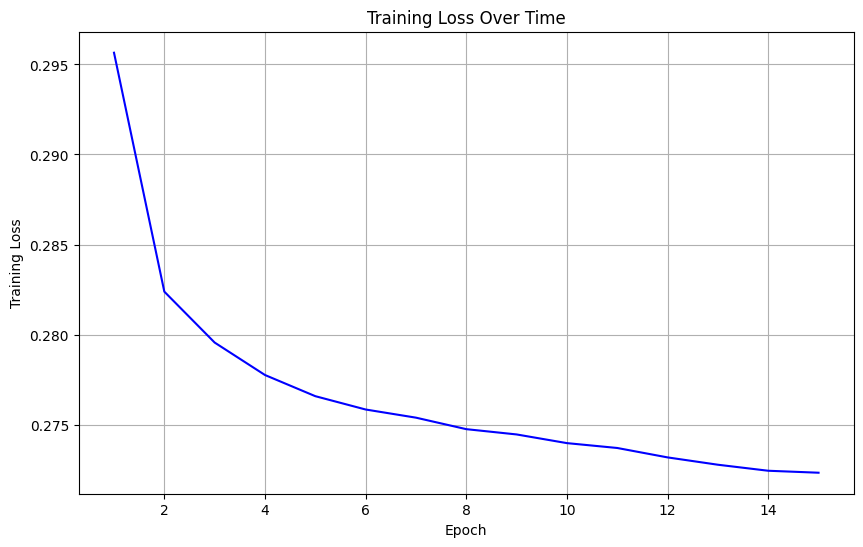

In [76]:
### Plot loss curve using Matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, 'b-')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

> **Q6.1)  How do you know when your network is done training?**

when loss become too small over time, with this model it probably was so after 10 epoch



Another way to check if your models (`HNet` and `MyNet`) are well trained is to plot a few image reconstructions to see how well your models do.

In [77]:
# extract 6 figures from training DataLoader
mini_batch, _ = next(iter(train_loader))
n_examples = min(6, mini_batch.shape[0])
examples = mini_batch[:n_examples]

# compute reconstructions
with torch.no_grad():
    reconstr_examples = model.forward(
        examples.view(n_examples, -1).to(device))

# save image with original v. reconstructed images
comparison = torch.cat([
    examples,
    reconstr_examples.view(-1, 1, 28, 28).cpu()])
save_image(comparison.cpu(), 'training_reconstruction.png', nrow=n_examples)

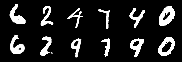

In [78]:
Image('training_reconstruction.png', width=300)

> **Q6.2) What does `torch.no_grad()` do?**

it disable gradient calculation because we don't need it at this point we are just evaluating model performance not training it

### 7. Visualize the learning process

We'll next try to visualize how well the model is learning on the **test set**. To do this, we'll first visualize the "learning process" by viewing reconstruction at various stages.

* Using your checkpoints saved during training, plot a batch of images from the test set and their corresponding reconstructions based on each of your saved models over time. You should see the quality of the reconstructions improving over time.
* To visualize images, you can use the helper functions provided below.


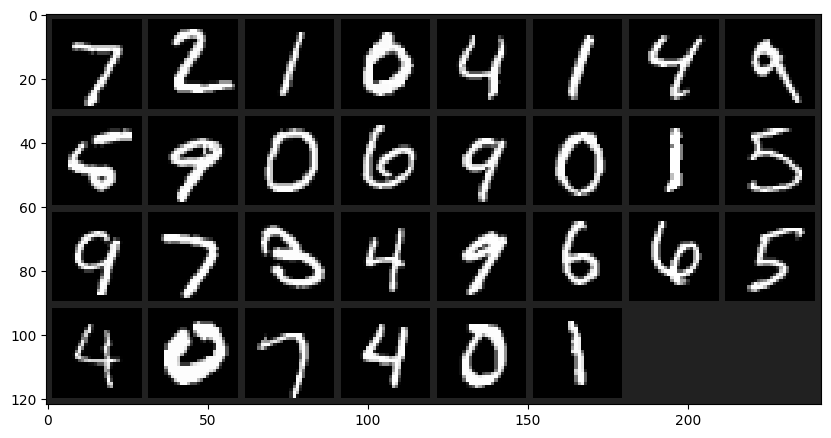

In [79]:
### Helper Functions for Plotting Multiple Images

def imshow(inp,
           figsize=(10,10),
           mean=0.1307, # for MNIST train
           std=0.3081, # for MNIST train
           title=None):
    """Imshow for Tensor."""
    inp = inp.cpu().detach()
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=figsize)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def reconstructions_from_batch(model, batch):
    batch = batch.view(-1, 28 * 28).to(device)
    reconstruction = model(batch)
    return reconstruction.reshape(batch.shape[0],1,28,28)

# Get a batch of training data
batch, classes = next(iter(test_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(batch)
imshow(out)

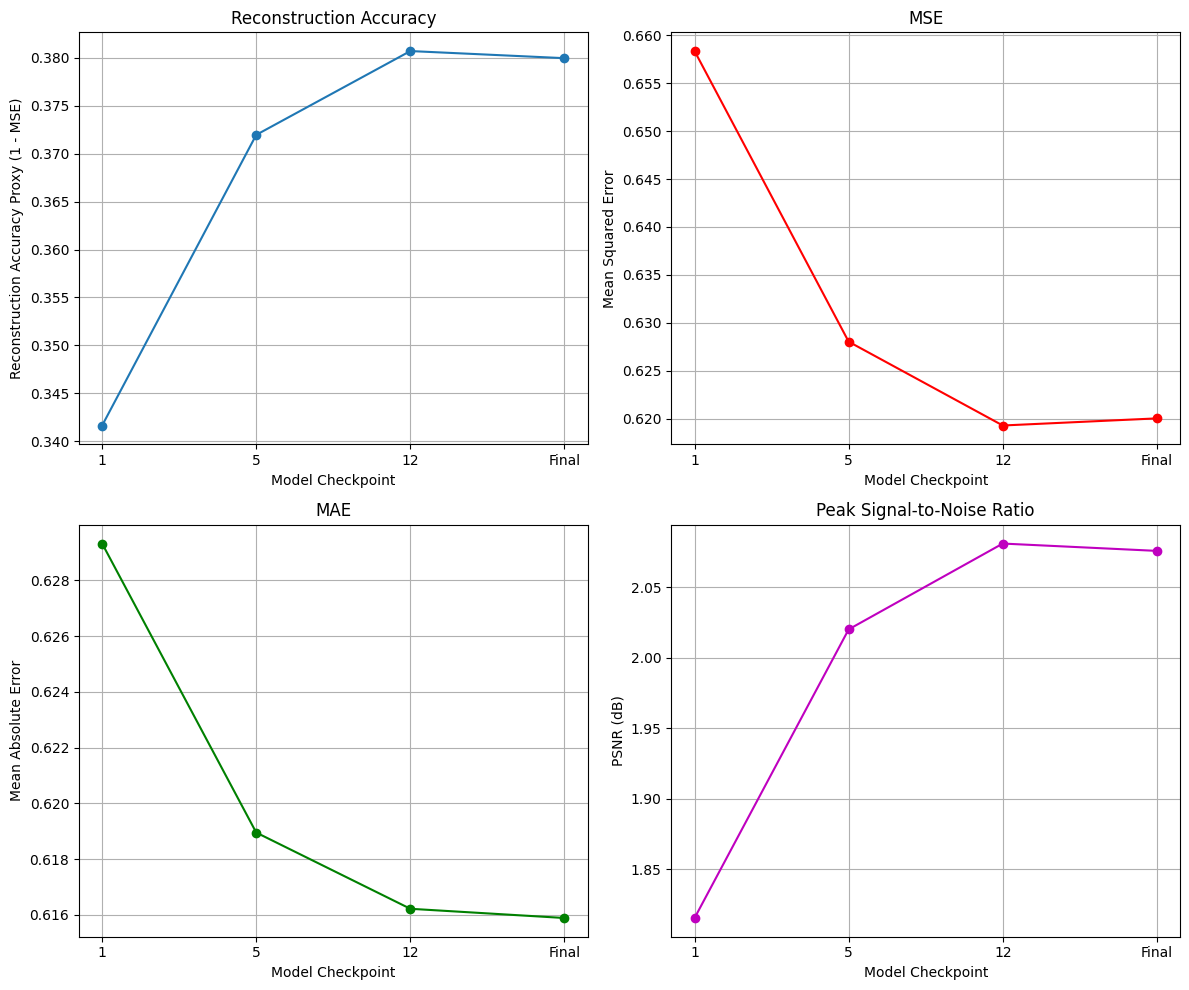

In [83]:
### Plot reconstruction metrics for checkpoint model copies at epochs 1, 5, and 12 and for the final model
### Evaluating performance on a fixed test batch from the test_loader

import math

# Get a batch of test images that we'll reuse for evaluation
batch, classes = next(iter(test_loader))
batch = batch.to(device)

# Define the target models including checkpoints and the final trained model.
# Tuple format: (model identifier, label for plotting)
target_models = [('epoch_1', 1), ('epoch_5', 5), ('epoch_12', 12), ('final', 'Final')]

# Initialize lists to store metrics for each model
labels_for_plot = []
recon_accuracy = []  # proxy defined as (1 - MSE)
mse_list = []
mae_list = []
psnr_list = []  # Peak Signal-to-Noise Ratio

# Evaluate model performance using both checkpoint models drawn from checkpoint_models and the final model
for identifier, label in target_models:
    # Select model: if identifier is 'final', use the final trained model; otherwise, grab the checkpoint copy
    if identifier == 'final':
        current_model = model
    elif identifier in checkpoint_models:
        current_model = checkpoint_models[identifier]
    else:
        continue  # skip unavailable checkpoint

    current_model.eval()
    with torch.no_grad():
        # Generate reconstructions for the fixed test batch
        reconstructions = reconstructions_from_batch(current_model, batch)
        # Compute Mean Squared Error (MSE)
        mse = torch.mean((batch - reconstructions)**2).item()
        # Compute Mean Absolute Error (MAE)
        mae = torch.mean(torch.abs(batch - reconstructions)).item()
        # Use (1 - MSE) as a proxy for reconstruction accuracy (illustrative metric)
        accuracy_proxy = 1 - mse
        # Compute Peak Signal-to-Noise Ratio (PSNR), assuming image pixels in [0, 1]
        psnr_val = 10 * math.log10(1 / mse) if mse > 0 else float('inf')
        
        # Append computed metrics
        labels_for_plot.append(label)
        recon_accuracy.append(accuracy_proxy)
        mse_list.append(mse)
        mae_list.append(mae)
        psnr_list.append(psnr_val)

# Create a grid of subplots to display the performance metrics
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(labels_for_plot, recon_accuracy, marker='o', linestyle='-')
plt.xlabel('Model Checkpoint')
plt.ylabel('Reconstruction Accuracy Proxy (1 - MSE)')
plt.title('Reconstruction Accuracy')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(labels_for_plot, mse_list, marker='o', color='r', linestyle='-')
plt.xlabel('Model Checkpoint')
plt.ylabel('Mean Squared Error')
plt.title('MSE')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(labels_for_plot, mae_list, marker='o', color='g', linestyle='-')
plt.xlabel('Model Checkpoint')
plt.ylabel('Mean Absolute Error')
plt.title('MAE')
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(labels_for_plot, psnr_list, marker='o', color='m', linestyle='-')
plt.xlabel('Model Checkpoint')
plt.ylabel('PSNR (dB)')
plt.title('Peak Signal-to-Noise Ratio')
plt.grid(True)

plt.tight_layout()
plt.show()

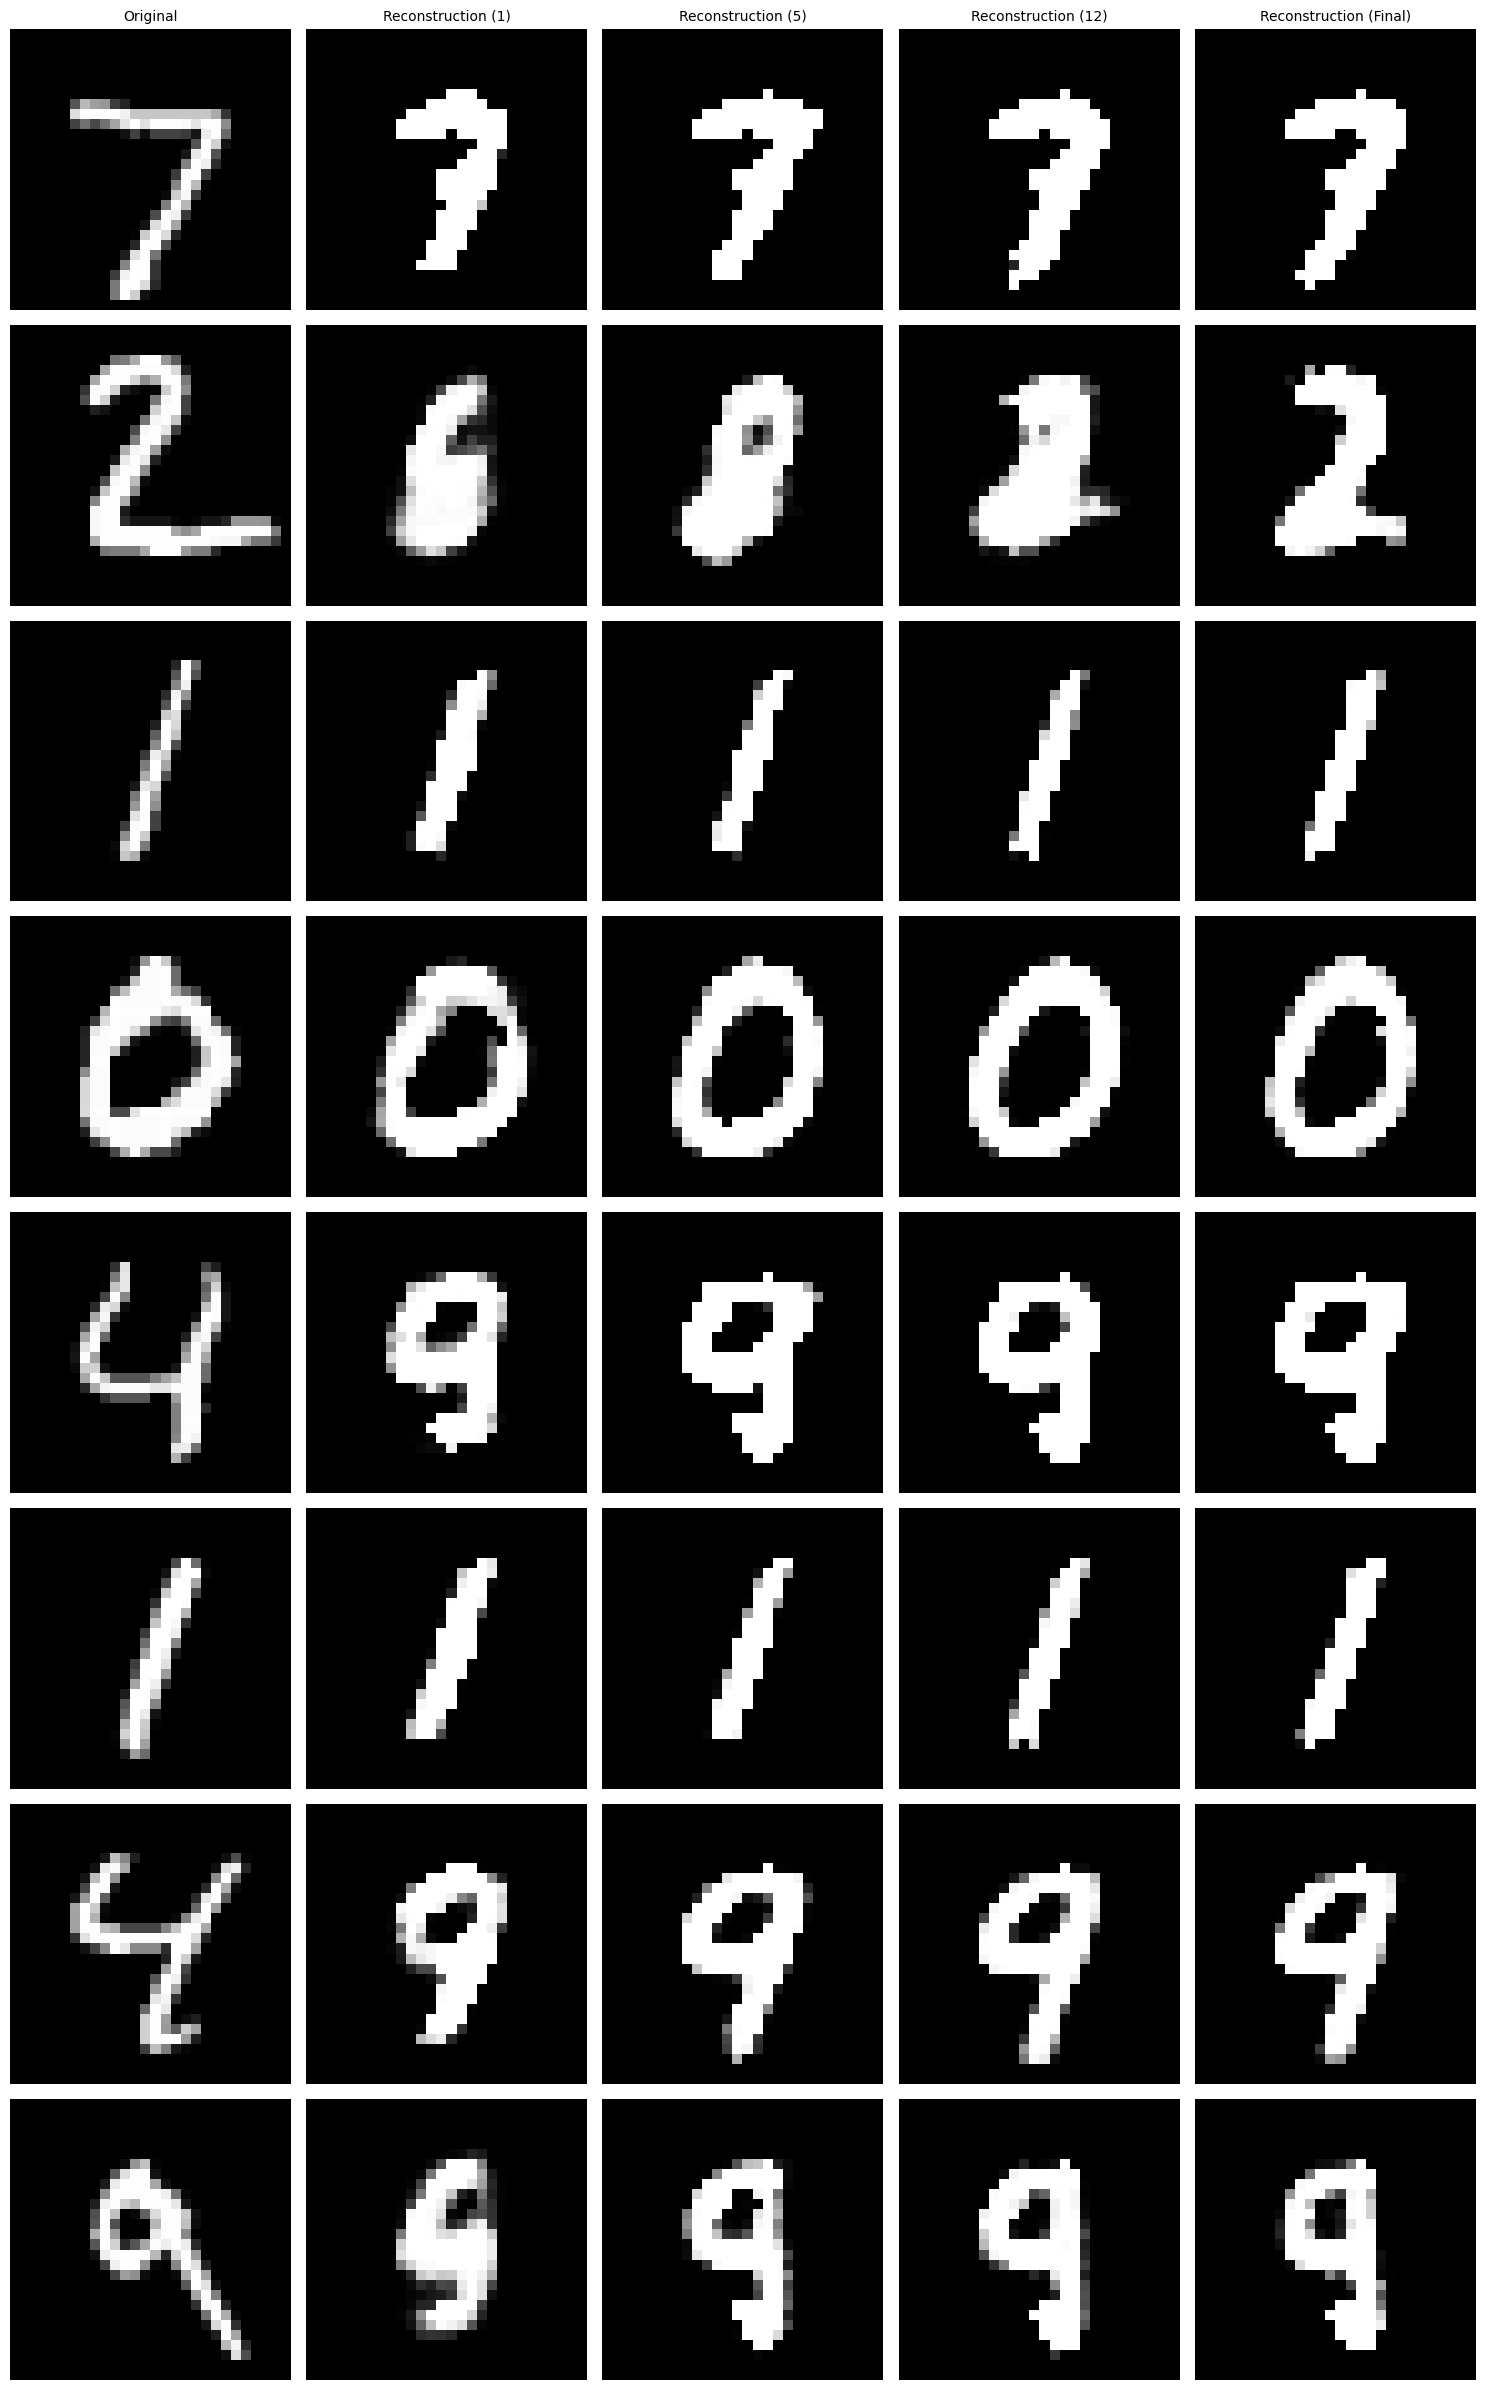

In [89]:
# Reconstruct and visualize original vs. reconstructed images from models at different stages

# Determine which target models are available (either 'final' or present in checkpoint_models)
available_targets = []
for identifier, label in target_models:
    if identifier == 'final' or identifier in checkpoint_models:
        available_targets.append((identifier, label))

# Compute reconstructions for each available target model using the fixed test batch.
reconstructions_dict = {}
for identifier, label in available_targets:
    if identifier == 'final':
        current_model = model
    else:
        current_model = checkpoint_models[identifier]
    current_model.eval()
    with torch.no_grad():
        recon = reconstructions_from_batch(current_model, batch)
    reconstructions_dict[label] = recon.cpu()  # move to CPU for plotting

# Select a few images from the test batch to display (limit to 6 images)
n_show = min(batch.size(0), 8)

# Create a grid of subplots:
# Columns: one for the original images + one per available target model.
# Rows: one per selected image.
n_cols = len(available_targets) + 1
n_rows = n_show

fig, axes = plt.subplots(n_rows, n_cols, figsize=(3 * n_cols, 3 * n_rows))
# Ensure axes is 2D even if n_show==1
if n_rows == 1:
    axes = axes[None, :]

# Plot the original images in the first column
batch_cpu = batch.cpu()
for i in range(n_show):
    orig_img = batch_cpu[i].squeeze()  # remove any extra dimensions (e.g., channel)
    ax = axes[i, 0]
    ax.imshow(orig_img, cmap='gray')
    if i == 0:
        ax.set_title("Original", fontsize=10)
    ax.axis('off')

# Plot the corresponding reconstructed images for each target model
for j, (identifier, label) in enumerate(available_targets):
    recon_vals = reconstructions_dict[label]
    for i in range(n_show):
        recon_img = recon_vals[i].squeeze()
        ax = axes[i, j + 1]
        ax.imshow(recon_img, cmap='gray')
        if i == 0:
            ax.set_title(f"Reconstruction ({label})", fontsize=10)
        ax.axis('off')

plt.tight_layout()
plt.show()


### 8. Visualize the latent space

As discussed in class, the first half of an autoencoder (the *encoder*) maps the original input into a lower-dimensional latent space.
* Just as shown in Hinton and Salakhutdinov, run your test set of 10,000 MNIST digits through the **encoding layer** of one of the trained networks above. Each sample should readily map to a 2-dimension point. To do this, it will be helpful to fill out a new function, **encode** below, that takes in your trained model and the `test_dataloader` to produce 2d latent embeddings and their corresponding labels.
* Plot each point in these two dimensions, and color each point in this **latent space** by their known **labels**.


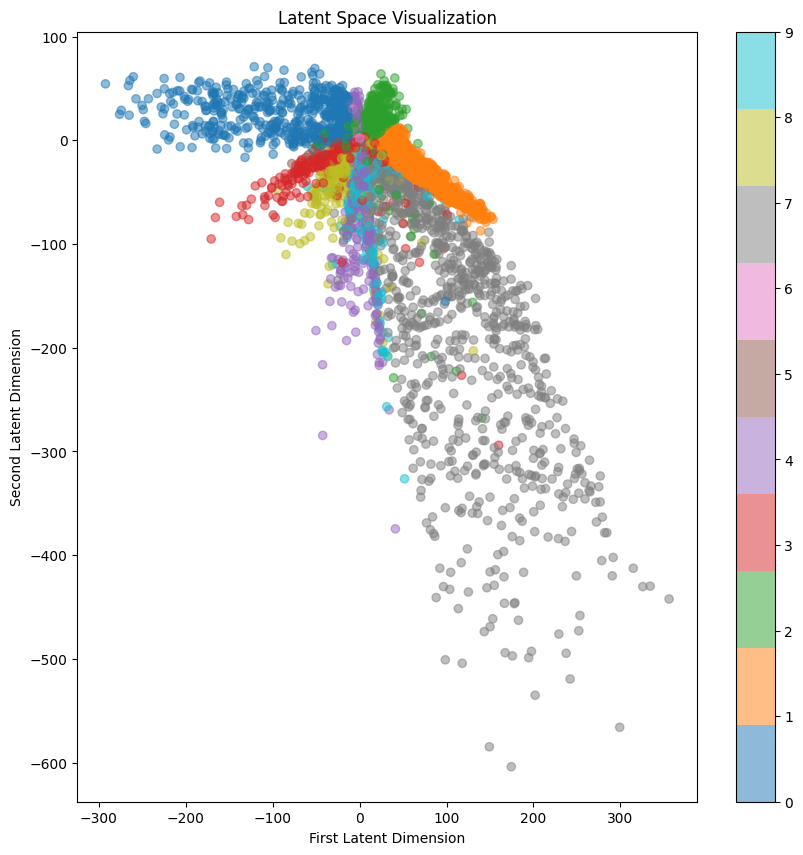

In [84]:
### Write a helper function to grab examples from the test_loader to generate
### pairs of embeddings and their associated labels

def encode(model, device, test_loader):
    model.eval()
    latent_embeddings = []
    labels = []
    
    with torch.no_grad():
        for data, label in test_loader:
            # Move data to device and flatten
            data = data.view(-1, 28 * 28).to(device)
            
            # Get latent embeddings by running through encoder part of model
            latent = model.encoder(data)
            
            # Append embeddings and labels
            latent_embeddings.append(latent)
            labels.append(label)
    
    # Concatenate all batches
    latent_embeddings = torch.cat(latent_embeddings, dim=0)
    labels = torch.cat(labels, dim=0)
    
    return latent_embeddings.cpu().numpy(), labels.cpu().numpy()

### Plot latent space representation color-coded
### according to their "true" labels
latent_embeddings, labels = encode(model, device, test_loader)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(latent_embeddings[:, 0], latent_embeddings[:, 1], 
                     c=labels, cmap='tab10', alpha=0.5)
plt.colorbar(scatter)
plt.title('Latent Space Visualization')
plt.xlabel('First Latent Dimension')
plt.ylabel('Second Latent Dimension')
plt.show()

> **Q8.1) Does your autoencoder separate out different classes effectively? What classes seem to be closer and what classes are farther apart in this latent space?**

yes it does, 
- it seems to be 4 and 6 and 9 and 8 are all clumped into similar latent space, it think because they all contain circules in them. 
- what it seem to be more distinct is that 1 and 2 and 0 have clear latent space 
- what is really intresting is that 9 and 4 are very close in latent space, they indeed look very similar!

## Optional (advanced): Train an autoencoder on CelebA Faces

Real-world images tend to be far more complex than digits from MNIST. As an optional exercise for your own interest, or for students looking for more experience, we'll investigate a subset of CelebA below.

We provide the images in a .zip file (`faces.zip`) in the class's Google Drive folder, which contains a "train" and "test" set of 80k and 10k images, respectively. Although these are color, RGB images, below we've set up the datasets to convert these to grayscale with precomputed means (0.4401) and stds (0.2407), for convenience and easier compute.

In [ ]:
### Download faces.zip and unzip it into bmi219_downloads/

In [ ]:
preprocessing = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.4401,), (0.2407,)),
])

train_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/train',
    transform=preprocessing)

test_dataset = datasets.ImageFolder(
    'bmi219_downloads/Faces/test',
    transform=preprocessing)

As above, you'll want to:

1. set up your dataloaders and visualize some of the images
2. set up your autoencoder network architecture
3. define your training criterion and optimizer
4. train your network
    
In this case, you should be able to reuse much of your code from above. Consider a few questions:

1. How well do complex images like faces work with a latent dimension of 2?
2. Do reconstructions look better with a larger bottleneck?
3. What kind of features are poorly reconstructed? What happens to sunglasses, hats, and hands?
4. Try sampling the 2-d latent space close to existing examples (by adding some noise...) or randomly. What do the generated images look like?